**Step 1: Setup and Data Loading**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
df = pd.read_excel('/content/opioid_overdose_prediction_dataset.xlsx', sheet_name='Patient_Data')
print(f"Dataset loaded successfully! Shape: {df.shape}")

# Display basic information
print("\nDataset Overview:")
print("=" * 50)
print(f"Total records: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
df.head()

Loading dataset...
Dataset loaded successfully! Shape: (250, 27)

Dataset Overview:
Total records: 250
Total features: 27
Missing values: 131

First 5 rows of the dataset:


,patient_id,age,gender,weight_kg,height_cm,has_chronic_pain,has_mental_health_dx,history_of_substance_abuse,liver_disease,kidney_disease,...,concurrent_antidepressants,alcohol_use,tobacco_use,previous_overdose,daily_mme,risk_factors_count,risk_score,overdose_risk_label,risk_percentage,risk_category
0,1,69,Male,72,176,0,0,0,1,0,...,1,NaN,1,0,7.5,2,2.213918,0,21.9,Low Risk
1,2,32,Female,65,185,1,0,0,0,0,...,1,Light,0,0,6.1,1,1.569549,0,15.5,Low Risk
2,3,78,Male,70,182,0,0,0,0,1,...,1,NaN,1,1,20.0,3,4.682081,1,46.3,Moderate Risk
3,4,38,Male,63,176,0,0,1,0,0,...,0,Moderate,0,0,48.0,2,3.987188,1,39.4,Moderate Risk
4,5,41,Female,81,163,1,0,0,0,0,...,0,Heavy,1,0,5.6,2,3.708669,0,36.7,Moderate Risk


**Step 2: Data Exploration and Understanding**

In [ ]:
# Basic information about the dataset
print("Dataset Info:")
print("=" * 30)
df.info()

# Statistical summary
print("\nStatistical Summary:")
print("=" * 30)
df.describe()

# Check target variable distribution
print("\nTarget Variable Distribution:")
print("=" * 40)
print(df['overdose_risk_label'].value_counts())
print(f"High Risk Percentage: {df['overdose_risk_label'].mean()*100:.2f}%")

# Risk category distribution
print("\nRisk Category Distribution:")
print("=" * 35)
print(df['risk_category'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_id                   250 non-null    int64  
 1   age                          250 non-null    int64  
 2   gender                       250 non-null    object 
 3   weight_kg                    250 non-null    int64  
 4   height_cm                    250 non-null    int64  
 5   has_chronic_pain             250 non-null    int64  
 6   has_mental_health_dx         250 non-null    int64  
 7   history_of_substance_abuse   250 non-null    int64  
 8   liver_disease                250 non-null    int64  
 9   kidney_disease               250 non-null    int64  
 10  respiratory_disease          250 non-null    int64  
 11  primary_opioid               250 non-null    object 
 12  daily_dosage_mg              250 non-null    int64  
 13  treatm

**Step 3: Data Visualization**

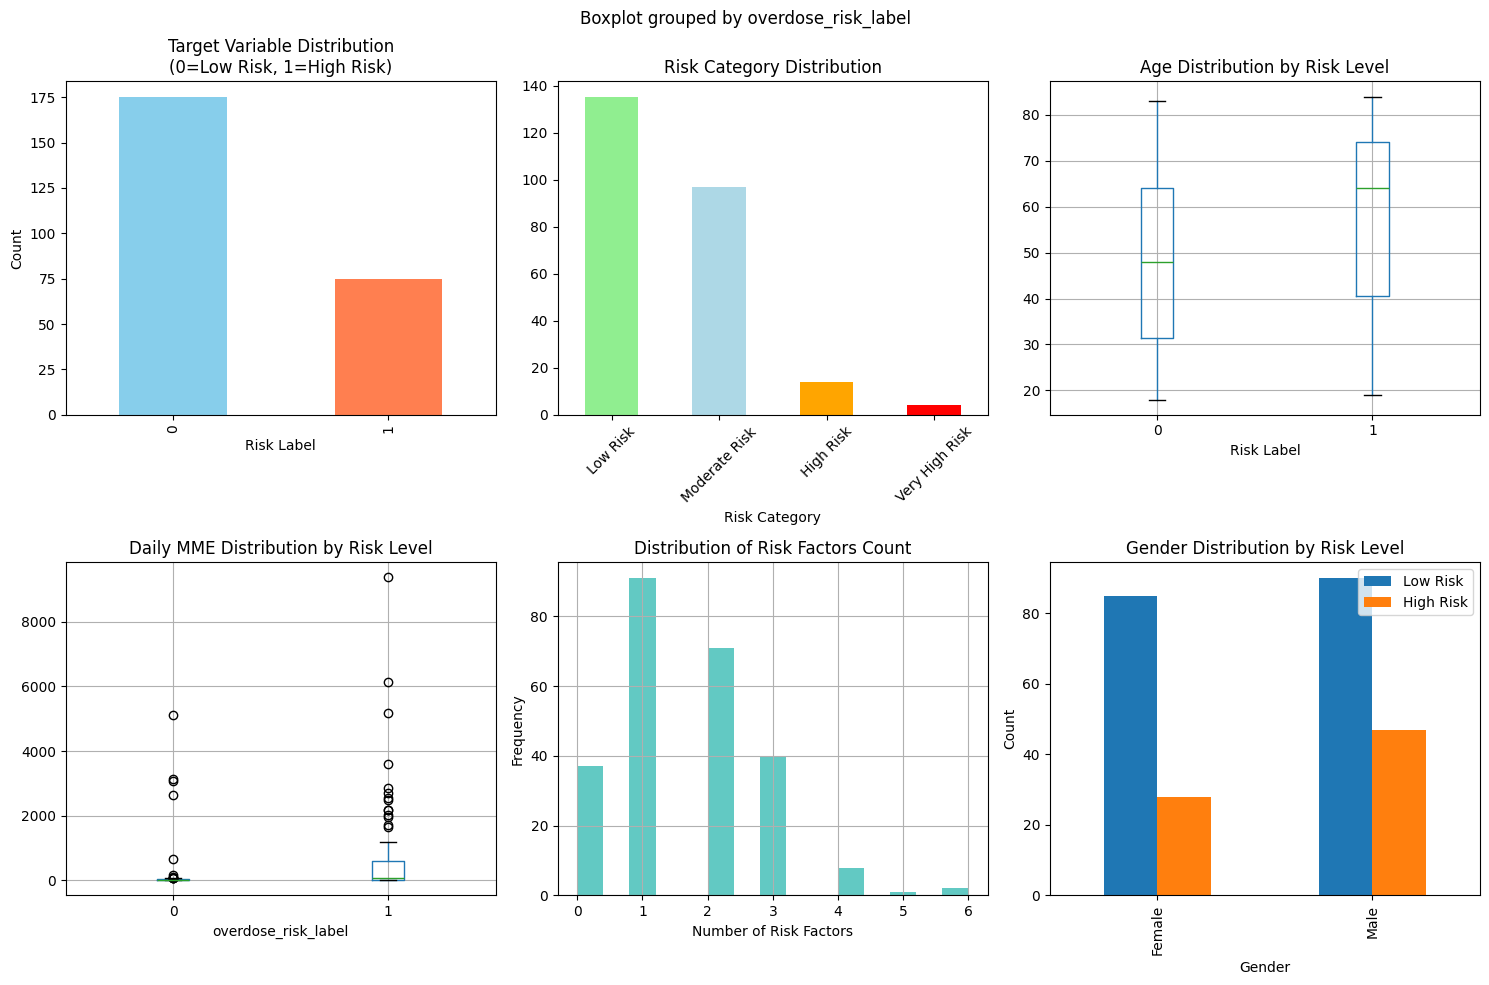

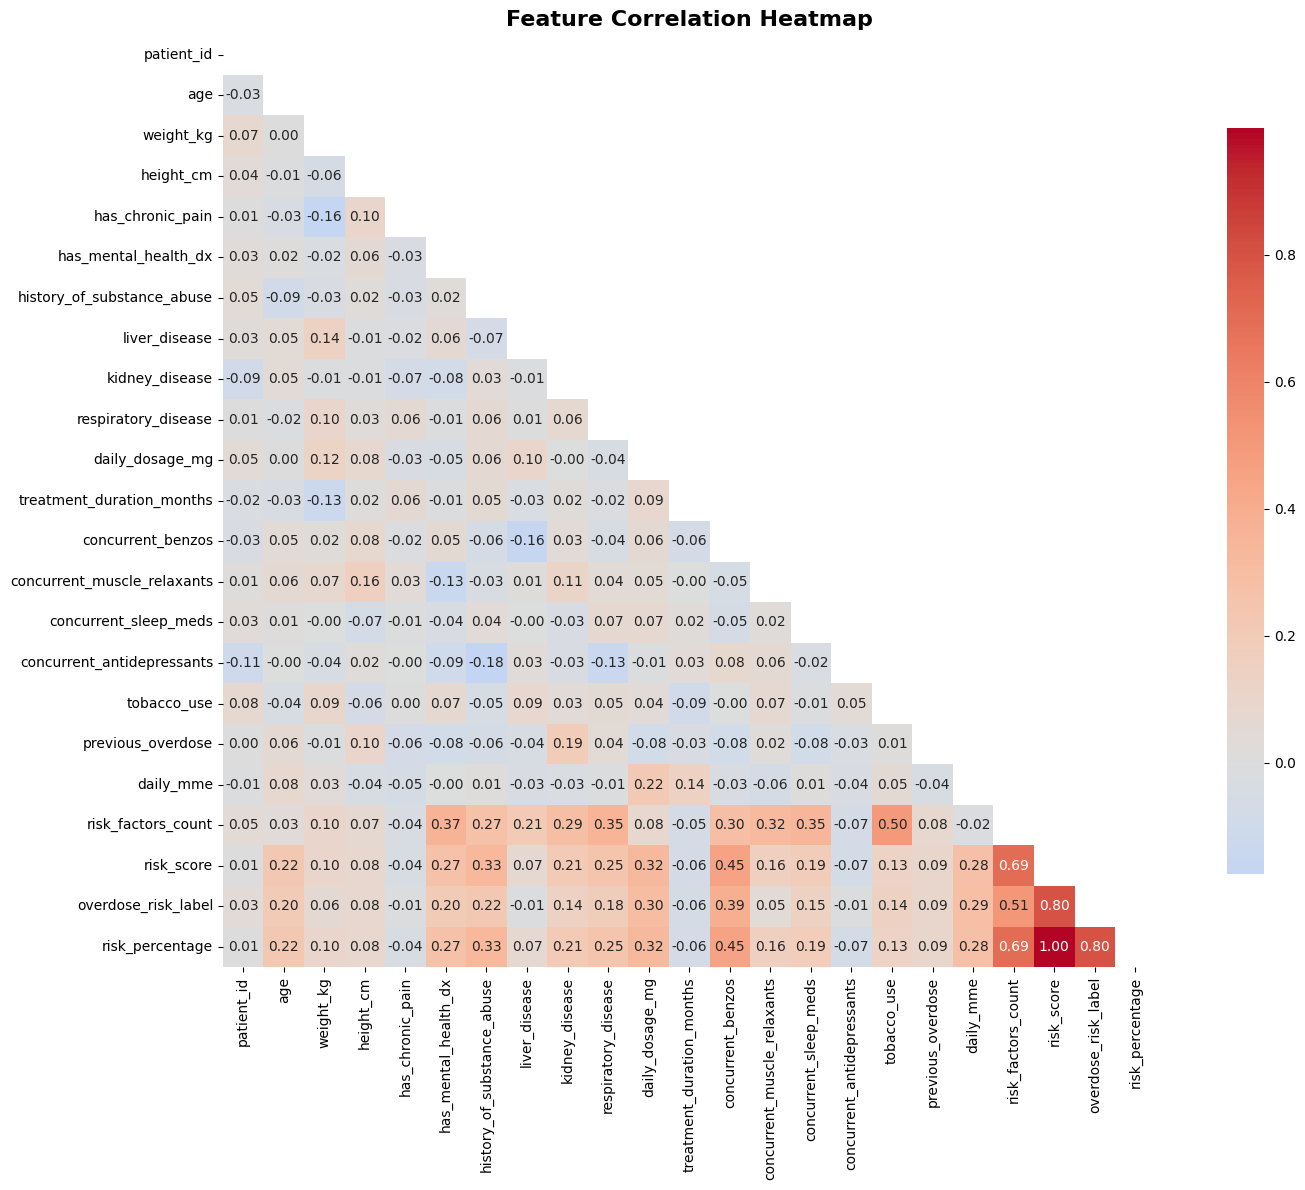

In [ ]:
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Target variable distribution
df['overdose_risk_label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'coral'])
axes[0,0].set_title('Target Variable Distribution\n(0=Low Risk, 1=High Risk)')
axes[0,0].set_xlabel('Risk Label')
axes[0,0].set_ylabel('Count')

# 2. Risk categories
df['risk_category'].value_counts().plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'lightblue', 'orange', 'red'])
axes[0,1].set_title('Risk Category Distribution')
axes[0,1].set_xlabel('Risk Category')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Age distribution by risk
df.boxplot(column='age', by='overdose_risk_label', ax=axes[0,2])
axes[0,2].set_title('Age Distribution by Risk Level')
axes[0,2].set_xlabel('Risk Label')

# 4. Daily MME by risk
df.boxplot(column='daily_mme', by='overdose_risk_label', ax=axes[1,0])
axes[1,0].set_title('Daily MME Distribution by Risk Level')
axes[1,1].set_xlabel('Risk Label')

# 5. Risk factors count
df['risk_factors_count'].hist(bins=15, ax=axes[1,1], color='lightseagreen', alpha=0.7)
axes[1,1].set_title('Distribution of Risk Factors Count')
axes[1,1].set_xlabel('Number of Risk Factors')
axes[1,1].set_ylabel('Frequency')

# 6. Gender distribution by risk
pd.crosstab(df['gender'], df['overdose_risk_label']).plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Gender Distribution by Risk Level')
axes[1,2].set_xlabel('Gender')
axes[1,2].set_ylabel('Count')
axes[1,2].legend(['Low Risk', 'High Risk'])

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Step 4: Data Preprocessing**

In [ ]:
print("Starting Data Preprocessing...")
print("=" * 40)

# Create a copy of the original dataframe
df_processed = df.copy()

# Drop columns that are targets or identifiers
columns_to_drop = ['patient_id', 'risk_score', 'risk_percentage', 'risk_category']
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

print("Columns after dropping identifiers and targets:")
print(df_processed.columns.tolist())

# Handle categorical variables
print("\nEncoding categorical variables...")
categorical_columns = ['gender', 'primary_opioid', 'alcohol_use']
label_encoders = {}

for col in categorical_columns:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Drop original categorical columns
df_processed = df_processed.drop(columns=categorical_columns, errors='ignore')

# Define features and target
X = df_processed.drop('overdose_risk_label', axis=1)
y = df_processed['overdose_risk_label']

print(f"\nFinal feature set shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Display feature names
print("\nFeatures used for modeling:")
for i, feature in enumerate(X.columns, 1):
    print(f"{i:2d}. {feature}")

Starting Data Preprocessing...
Columns after dropping identifiers and targets:
['age', 'gender', 'weight_kg', 'height_cm', 'has_chronic_pain', 'has_mental_health_dx', 'history_of_substance_abuse', 'liver_disease', 'kidney_disease', 'respiratory_disease', 'primary_opioid', 'daily_dosage_mg', 'treatment_duration_months', 'concurrent_benzos', 'concurrent_muscle_relaxants', 'concurrent_sleep_meds', 'concurrent_antidepressants', 'alcohol_use', 'tobacco_use', 'previous_overdose', 'daily_mme', 'risk_factors_count', 'overdose_risk_label']

Encoding categorical variables...
Encoded gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Encoded primary_opioid: {'Codeine': np.int64(0), 'Fentanyl': np.int64(1), 'Hydrocodone': np.int64(2), 'Morphine': np.int64(3), 'Oxycodone': np.int64(4), 'Tramadol': np.int64(5)}
Encoded alcohol_use: {'Heavy': np.int64(0), 'Light': np.int64(1), 'Moderate': np.int64(2), 'nan': np.int64(3)}

Final feature set shape: (250, 22)
Target variable shape: (250,)

Features us

**Step 5: Train-Test Split and Feature Scaling**

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split Summary:")
print("=" * 30)
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Training labels - High Risk: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Testing labels - High Risk: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed!")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled testing data shape: {X_test_scaled.shape}")

Data Split Summary:
Training set: (200, 22)
Testing set: (50, 22)
Training labels - High Risk: 60 (30.0%)
Testing labels - High Risk: 15 (30.0%)

Feature scaling completed!
Scaled training data shape: (200, 22)
Scaled testing data shape: (50, 22)


**Step 6: Model Training and Evaluation**

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models
results = {}

print("Training and Evaluating Models...")
print("=" * 45)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc_score': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC Score: {auc_score:.4f}")

# Compare model performance
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)

performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'AUC Score': [results[name]['auc_score'] for name in results.keys()]
}).sort_values('AUC Score', ascending=False)

print(performance_df)

Training and Evaluating Models...

Training Logistic Regression...
Logistic Regression Results:
  Accuracy: 0.8400
  AUC Score: 0.9219

Training Random Forest...
Random Forest Results:
  Accuracy: 0.7800
  AUC Score: 0.9010

Training Gradient Boosting...
Gradient Boosting Results:
  Accuracy: 0.8200
  AUC Score: 0.8629

Training SVM...
SVM Results:
  Accuracy: 0.8200
  AUC Score: 0.9162

MODEL PERFORMANCE COMPARISON
                 Model  Accuracy  AUC Score
0  Logistic Regression      0.84   0.921905
3                  SVM      0.82   0.916190
1        Random Forest      0.78   0.900952
2    Gradient Boosting      0.82   0.862857


**Step 7: Detailed Model Analysis**


Best Model: Logistic Regression

Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        35
           1       0.71      0.80      0.75        15

    accuracy                           0.84        50
   macro avg       0.81      0.83      0.82        50
weighted avg       0.85      0.84      0.84        50



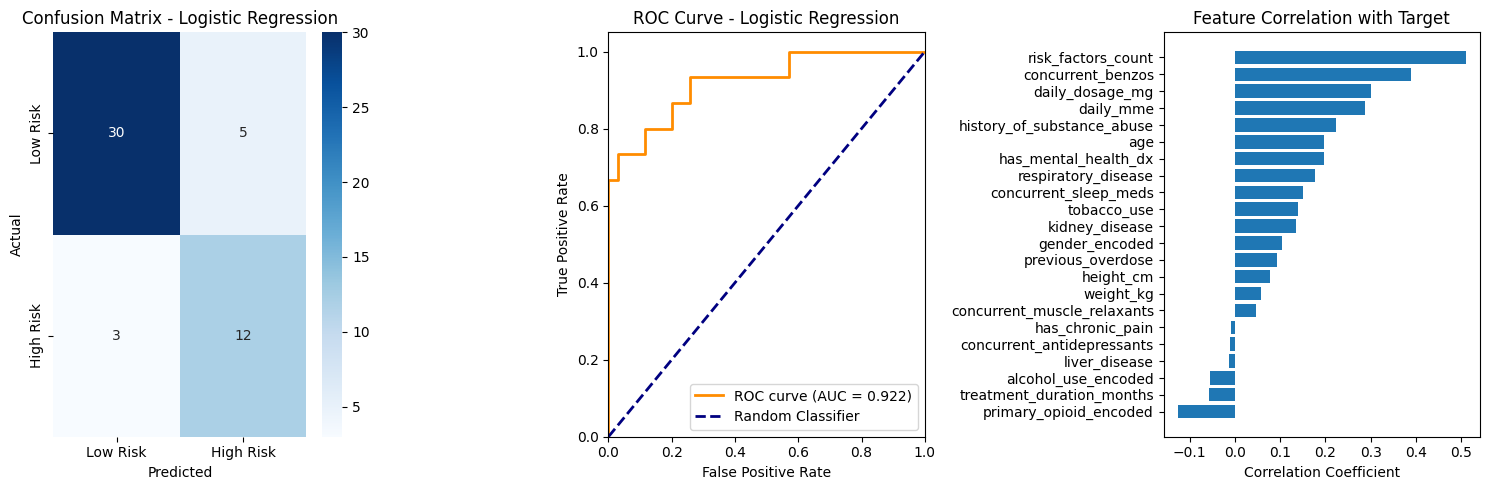

In [ ]:
# Select the best model based on AUC score
best_model_name = performance_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")

# Generate detailed classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print("=" * 55)

if best_model_name == 'SVM':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best))

# Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(1, 3, 2)
if best_model_name == 'SVM':
    y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
auc_score = roc_auc_score(y_test, y_pred_proba_best)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")

# Feature Importance (for tree-based models)
plt.subplot(1, 3, 3)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance Score')
else:
    # For non-tree models, show correlation with target
    correlation_with_target = X.corrwith(y).sort_values()
    plt.barh(correlation_with_target.index, correlation_with_target.values)
    plt.title('Feature Correlation with Target')
    plt.xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

**Step 8: Hyperparameter Tuning**

In [ ]:
print("Performing Hyperparameter Tuning...")
print("=" * 40)

# Tune Random Forest (usually performs well)
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_tuned = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    rf_tuned.fit(X_train, y_train)

    print(f"Best parameters: {rf_tuned.best_params_}")
    print(f"Best cross-validation score: {rf_tuned.best_score_:.4f}")

    # Update best model
    best_model = rf_tuned.best_estimator_
    best_model_name = "Tuned Random Forest"

# Evaluate tuned model
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"\nTuned Model Performance:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"AUC Score: {auc_tuned:.4f}")

Performing Hyperparameter Tuning...

Tuned Model Performance:
Accuracy: 0.8400
AUC Score: 0.9219


**Step 9: Model Saving and Deployment Preparation**

In [ ]:
print("\nSaving Model and Preprocessing Objects...")
print("=" * 45)

# Create a dictionary of all objects to save
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_names': X.columns.tolist(),
    'model_name': best_model_name,
    'performance_metrics': {
        'accuracy': accuracy_tuned if 'accuracy_tuned' in locals() else results[best_model_name]['accuracy'],
        'auc_score': auc_tuned if 'auc_tuned' in locals() else results[best_model_name]['auc_score']
    }
}

# Save the model artifacts
joblib.dump(model_artifacts, 'opioid_overdose_model.joblib')
print("Model artifacts saved as 'opioid_overdose_model.joblib'")

# Save individual components as well (for flexibility)
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("Individual components saved:")
print("  - best_model.pkl")
print("  - scaler.pkl")
print("  - label_encoders.pkl")


Saving Model and Preprocessing Objects...
Model artifacts saved as 'opioid_overdose_model.joblib'
Individual components saved:
  - best_model.pkl
  - scaler.pkl
  - label_encoders.pkl


**Step 10: Model Validation and Testing**

In [ ]:
print("\nFinal Model Validation")
print("=" * 35)

# Load the saved model to verify
loaded_artifacts = joblib.load('opioid_overdose_model.joblib')
loaded_model = loaded_artifacts['model']
loaded_scaler = loaded_artifacts['scaler']

print("Model loaded successfully!")

# Test prediction on a sample from test set
sample_idx = 0
sample_features = X_test.iloc[sample_idx:sample_idx+1]

if best_model_name == 'SVM' or 'SVM' in best_model_name:
    sample_scaled = loaded_scaler.transform(sample_features)
    prediction = loaded_model.predict(sample_scaled)
    probability = loaded_model.predict_proba(sample_scaled)
else:
    prediction = loaded_model.predict(sample_features)
    probability = loaded_model.predict_proba(sample_features)

print(f"\nSample Prediction Test:")
print(f"Actual Risk: {y_test.iloc[sample_idx]} ({'High Risk' if y_test.iloc[sample_idx] == 1 else 'Low Risk'})")
print(f"Predicted Risk: {prediction[0]} ({'High Risk' if prediction[0] == 1 else 'Low Risk'})")
print(f"Prediction Probability: [Low Risk: {probability[0][0]:.3f}, High Risk: {probability[0][1]:.3f}]")

# Final performance summary
print(f"\n{' FINAL MODEL SUMMARY ':=^50}")
print(f"Model: {loaded_artifacts['model_name']}")
print(f"Accuracy: {loaded_artifacts['performance_metrics']['accuracy']:.4f}")
print(f"AUC Score: {loaded_artifacts['performance_metrics']['auc_score']:.4f}")
print(f"Number of Features: {len(loaded_artifacts['feature_names'])}")
print(f"Dataset Size: {len(df)} records")
print("=" * 50)


Final Model Validation
Model loaded successfully!

Sample Prediction Test:
Actual Risk: 0 (Low Risk)
Predicted Risk: 0 (Low Risk)
Prediction Probability: [Low Risk: 0.986, High Risk: 0.014]

============== FINAL MODEL SUMMARY ===============
Model: Logistic Regression
Accuracy: 0.8400
AUC Score: 0.9219
Number of Features: 22
Dataset Size: 250 records


**Step 11: Download the Trained Model**

In [ ]:
from google.colab import files

# Download the model files
files_to_download = [
    'opioid_overdose_model.joblib',
    'best_model.pkl',
    'scaler.pkl',
    'label_encoders.pkl'
]

print("Downloading model files...")
for file in files_to_download:
    try:
        files.download(file)
        print(f"✓ Downloaded: {file}")
    except:
        print(f"✗ Could not download: {file}")

print("\n🎉 Machine Learning Pipeline Complete!")
print("All model files have been downloaded to your local machine.")
print("You can now integrate these with your FastAPI backend.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: opioid_overdose_model.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: best_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: label_encoders.pkl

🎉 Machine Learning Pipeline Complete!
All model files have been downloaded to your local machine.
You can now integrate these with your FastAPI backend.
